In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import AbstractDataset


data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
basis = "6-311++g**"
n_electrons = 16
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))


ind = int(0.8 * len(index))
ind_val = int(0.8 * ind)


molecules = (
    molecules[:ind_val], 
    molecules[ind_val:ind], 
    molecules[ind:]
)

s_triu_norm, mu, std = AbstractDataset.normalize(S)


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

s_train, p_train, s_test, p_test = split(S, P, ind)
s_train, p_train, s_val, p_val = split(s_train, p_train, ind_val)

## Utils 

In [3]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from SCFInitialGuess.utilities.dataset import extract_triu
from SCFInitialGuess.utilities.dataset import StaticDataset




def make_mask(mol, species):

    masks = []
    current_dim = 0
    for atom in mol.species:
        # calculate block range
        index_start = current_dim
        current_dim += N_BASIS[mol.basis][atom] 
        index_end = current_dim

        if atom == species:

            # calculate logical vector
            L = np.arange(dim)
            L = np.logical_and(index_start <= L, L < index_end)

            masks.append(np.logical_and.outer(L, L))
            
    
    return masks



def extract_dataset(molecules, p_batch, descriptor, species):    
    
    # make mask to extract central blocks
    masks = make_mask(molecules[0], species)
    
    descriptor_values, blocks = [], []
    for p, mol in zip(p_batch, molecules):
        for mask in masks:
            blocks.append(extract_triu(
                p.copy()[mask], 
                N_BASIS[mol.basis][species]
            ))
        
        for i, atom in enumerate(mol.species):
            if atom == species:
                descriptor_values.append(
                    descriptor.calculate_atom_descriptor(
                        i, 
                        mol,
                        descriptor.number_of_descriptors
                    )
                )
            
    return descriptor_values, blocks


def make_dataset(descriptor, species, dim):
    
    inputs_test, outputs_test = extract_dataset(
        molecules[2], 
        p_test.reshape(-1, dim, dim),
        descriptor,
        species
    )
    
    inputs_validation, outputs_validation = extract_dataset(
        molecules[1], 
        p_val.reshape(-1, dim, dim),
        descriptor,
        species
    )

    inputs_train, outputs_train = extract_dataset(
        molecules[0], 
        p_train.reshape(-1, dim, dim),
        descriptor,
        species
    )
    
    
    _, mu, std = StaticDataset.normalize(inputs_train + inputs_validation + inputs_test)
    
    dataset = StaticDataset(
        train=(
            StaticDataset.normalize(inputs_train, mean=mu, std=std)[0], 
            np.asarray(outputs_train)
        ),
        validation=(
            StaticDataset.normalize(inputs_validation, mean=mu, std=std)[0], 
            np.asarray(outputs_validation)
        ),
        test=(
            StaticDataset.normalize(inputs_test, mean=mu, std=std)[0], 
            np.asarray(outputs_test)
        ),
        mu=mu,
        std=std
    )
    
    return dataset

# Exec 

In [4]:
DIM = {
    "H": int(7*8 / 2),
    "C": int(22 * 23 / 2)
}

species="C"


In [32]:
from SCFInitialGuess.descriptors.high_level import \
    NonWeighted, AtomicNumberWeighted, ElectronegativityWeighted
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, PeriodicGaussians, EmptyGaussians
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    IndependentAngularDescriptor, SPHAngularDescriptor, ConstantAngularDescriptor
from SCFInitialGuess.descriptors.cutoffs import \
    BehlerCutoff1, Damping, ConstantCutoff


descriptor = NonWeighted(
    Gaussians(*make_radial_evenly(15)),
    SPHAngularDescriptor(5),
    BehlerCutoff1(2)
)

#descriptor = NonWeighted(
#    EmptyGaussians(),
#    ConstantAngularDescriptor(),
#    ConstantCutoff()
#)


In [33]:
dataset = make_dataset(descriptor, species, dim)

In [36]:
keras.backend.clear_session()

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)
input_dim = descriptor.number_of_descriptors
output_dim = DIM[species]
activation="elu", 
learning_rate=1e-3


model = keras.Sequential()

# linear model => 1 layer

model.add(keras.layers.Dense(
    output_dim, 
    #activation=activation, 
    input_dim=input_dim, 
    #kernel_initializer=intializer, 
    #bias_initializer='zeros',
    kernel_regularizer=keras.regularizers.l2(1e-8)
))


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate), 
    loss='MSE', 
    metrics=['mse']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 253)               22264     
Total params: 22,264
Trainable params: 22,264
Non-trainable params: 0
_________________________________________________________________


In [35]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-10, 
    patience=200, 
    verbose=1
)


reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.5, 
    patience=30, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=20, 
    min_lr=1e-8
)

EPOCHS = 5000

history = model.fit(
    x = dataset.training[0],
    y = dataset.training[1],
    epochs=EPOCHS,
    shuffle=True,
    validation_data=dataset.validation, 
    verbose=1, 
    callbacks=[
        early_stopping, 
        reduce_lr
    ]
)



Train on 1280 samples, validate on 320 samples
Epoch 1/5000
1280/1280 [==============================] - 0s 168us/step - loss: 0.3112 - mean_squared_error: 0.3112 - val_loss: 0.1701 - val_mean_squared_error: 0.1701
Epoch 2/5000
1280/1280 [==============================] - 0s 59us/step - loss: 0.1140 - mean_squared_error: 0.1140 - val_loss: 0.0684 - val_mean_squared_error: 0.0684
Epoch 3/5000
1280/1280 [==============================] - 0s 55us/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 4/5000
1280/1280 [==============================] - 0s 56us/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 5/5000
1280/1280 [==============================] - 0s 57us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 6/5000
1280/1280 [==============================] - 0s 65us/step - loss: 0.0073 - mean_squared_error: 0.0073 - 

1280/1280 [==============================] - 0s 72us/step - loss: 3.5847e-04 - mean_squared_error: 3.5788e-04 - val_loss: 3.9682e-04 - val_mean_squared_error: 3.9623e-04
Epoch 47/5000
1280/1280 [==============================] - 0s 59us/step - loss: 3.5307e-04 - mean_squared_error: 3.5249e-04 - val_loss: 3.9722e-04 - val_mean_squared_error: 3.9663e-04
Epoch 48/5000
1280/1280 [==============================] - 0s 60us/step - loss: 3.5005e-04 - mean_squared_error: 3.4947e-04 - val_loss: 3.9994e-04 - val_mean_squared_error: 3.9936e-04
Epoch 49/5000
1280/1280 [==============================] - 0s 64us/step - loss: 3.5204e-04 - mean_squared_error: 3.5145e-04 - val_loss: 3.9843e-04 - val_mean_squared_error: 3.9785e-04
Epoch 50/5000
1280/1280 [==============================] - 0s 54us/step - loss: 3.5205e-04 - mean_squared_error: 3.5147e-04 - val_loss: 3.9735e-04 - val_mean_squared_error: 3.9676e-04
Epoch 51/5000
1280/1280 [==============================] - 0s 57us/step - loss: 3.4646e-04 - m

1280/1280 [==============================] - 0s 66us/step - loss: 3.2671e-04 - mean_squared_error: 3.2616e-04 - val_loss: 3.9164e-04 - val_mean_squared_error: 3.9110e-04
Epoch 91/5000
1280/1280 [==============================] - 0s 55us/step - loss: 3.3176e-04 - mean_squared_error: 3.3122e-04 - val_loss: 3.7966e-04 - val_mean_squared_error: 3.7912e-04
Epoch 92/5000
1280/1280 [==============================] - 0s 54us/step - loss: 3.3256e-04 - mean_squared_error: 3.3202e-04 - val_loss: 3.8922e-04 - val_mean_squared_error: 3.8868e-04
Epoch 93/5000
1280/1280 [==============================] - 0s 61us/step - loss: 3.2865e-04 - mean_squared_error: 3.2811e-04 - val_loss: 4.0367e-04 - val_mean_squared_error: 4.0313e-04
Epoch 94/5000
1280/1280 [==============================] - 0s 89us/step - loss: 3.3245e-04 - mean_squared_error: 3.3191e-04 - val_loss: 3.9135e-04 - val_mean_squared_error: 3.9081e-04
Epoch 95/5000
1280/1280 [==============================] - 0s 94us/step - loss: 3.2815e-04 - m

Epoch 134/5000
1280/1280 [==============================] - 0s 64us/step - loss: 3.0107e-04 - mean_squared_error: 3.0055e-04 - val_loss: 3.6311e-04 - val_mean_squared_error: 3.6258e-04
Epoch 135/5000
1280/1280 [==============================] - 0s 80us/step - loss: 3.0196e-04 - mean_squared_error: 3.0143e-04 - val_loss: 3.6361e-04 - val_mean_squared_error: 3.6309e-04
Epoch 136/5000
1280/1280 [==============================] - 0s 106us/step - loss: 3.0509e-04 - mean_squared_error: 3.0457e-04 - val_loss: 3.6478e-04 - val_mean_squared_error: 3.6426e-04
Epoch 137/5000
1280/1280 [==============================] - 0s 54us/step - loss: 3.0515e-04 - mean_squared_error: 3.0463e-04 - val_loss: 3.7060e-04 - val_mean_squared_error: 3.7008e-04
Epoch 138/5000
1280/1280 [==============================] - 0s 54us/step - loss: 3.0812e-04 - mean_squared_error: 3.0759e-04 - val_loss: 3.6343e-04 - val_mean_squared_error: 3.6290e-04
Epoch 139/5000
1280/1280 [==============================] - 0s 49us/step -

Epoch 178/5000
1280/1280 [==============================] - 0s 73us/step - loss: 2.8744e-04 - mean_squared_error: 2.8692e-04 - val_loss: 3.4807e-04 - val_mean_squared_error: 3.4755e-04
Epoch 179/5000
1280/1280 [==============================] - 0s 53us/step - loss: 2.8557e-04 - mean_squared_error: 2.8505e-04 - val_loss: 3.4801e-04 - val_mean_squared_error: 3.4750e-04
Epoch 180/5000
1280/1280 [==============================] - 0s 55us/step - loss: 2.8572e-04 - mean_squared_error: 2.8520e-04 - val_loss: 3.5203e-04 - val_mean_squared_error: 3.5151e-04
Epoch 181/5000
1280/1280 [==============================] - 0s 62us/step - loss: 2.8787e-04 - mean_squared_error: 2.8736e-04 - val_loss: 3.5199e-04 - val_mean_squared_error: 3.5147e-04
Epoch 182/5000
1280/1280 [==============================] - 0s 84us/step - loss: 2.8465e-04 - mean_squared_error: 2.8413e-04 - val_loss: 3.4769e-04 - val_mean_squared_error: 3.4717e-04
Epoch 183/5000
1280/1280 [==============================] - 0s 86us/step - 

Epoch 222/5000
1280/1280 [==============================] - 0s 54us/step - loss: 2.7656e-04 - mean_squared_error: 2.7604e-04 - val_loss: 3.4455e-04 - val_mean_squared_error: 3.4404e-04
Epoch 223/5000
1280/1280 [==============================] - 0s 56us/step - loss: 2.7716e-04 - mean_squared_error: 2.7665e-04 - val_loss: 3.4576e-04 - val_mean_squared_error: 3.4525e-04
Epoch 224/5000
1280/1280 [==============================] - 0s 50us/step - loss: 2.7650e-04 - mean_squared_error: 2.7599e-04 - val_loss: 3.4214e-04 - val_mean_squared_error: 3.4163e-04
Epoch 225/5000
1280/1280 [==============================] - 0s 52us/step - loss: 2.7648e-04 - mean_squared_error: 2.7597e-04 - val_loss: 3.4361e-04 - val_mean_squared_error: 3.4309e-04
Epoch 226/5000
1280/1280 [==============================] - 0s 68us/step - loss: 2.7662e-04 - mean_squared_error: 2.7611e-04 - val_loss: 3.4501e-04 - val_mean_squared_error: 3.4450e-04
Epoch 227/5000
1280/1280 [==============================] - 0s 53us/step - 

1280/1280 [==============================] - 0s 63us/step - loss: 2.7263e-04 - mean_squared_error: 2.7211e-04 - val_loss: 3.4277e-04 - val_mean_squared_error: 3.4225e-04
Epoch 267/5000
1280/1280 [==============================] - 0s 61us/step - loss: 2.7168e-04 - mean_squared_error: 2.7117e-04 - val_loss: 3.4207e-04 - val_mean_squared_error: 3.4156e-04
Epoch 268/5000
1280/1280 [==============================] - 0s 55us/step - loss: 2.7131e-04 - mean_squared_error: 2.7079e-04 - val_loss: 3.4061e-04 - val_mean_squared_error: 3.4010e-04
Epoch 269/5000
1280/1280 [==============================] - 0s 53us/step - loss: 2.7176e-04 - mean_squared_error: 2.7124e-04 - val_loss: 3.4126e-04 - val_mean_squared_error: 3.4075e-04
Epoch 270/5000
1280/1280 [==============================] - 0s 51us/step - loss: 2.7166e-04 - mean_squared_error: 2.7115e-04 - val_loss: 3.4133e-04 - val_mean_squared_error: 3.4082e-04
Epoch 271/5000
1280/1280 [==============================] - 0s 54us/step - loss: 2.7154e-0

1280/1280 [==============================] - 0s 62us/step - loss: 2.7181e-04 - mean_squared_error: 2.7130e-04 - val_loss: 3.4113e-04 - val_mean_squared_error: 3.4062e-04
Epoch 311/5000
1280/1280 [==============================] - 0s 54us/step - loss: 2.7179e-04 - mean_squared_error: 2.7128e-04 - val_loss: 3.4291e-04 - val_mean_squared_error: 3.4240e-04
Epoch 312/5000
1280/1280 [==============================] - 0s 55us/step - loss: 2.7173e-04 - mean_squared_error: 2.7122e-04 - val_loss: 3.4086e-04 - val_mean_squared_error: 3.4035e-04
Epoch 313/5000
1280/1280 [==============================] - 0s 51us/step - loss: 2.7153e-04 - mean_squared_error: 2.7102e-04 - val_loss: 3.4239e-04 - val_mean_squared_error: 3.4188e-04
Epoch 314/5000
1280/1280 [==============================] - 0s 53us/step - loss: 2.7193e-04 - mean_squared_error: 2.7142e-04 - val_loss: 3.4263e-04 - val_mean_squared_error: 3.4212e-04

Epoch 00314: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 315

Epoch 354/5000
1280/1280 [==============================] - 0s 55us/step - loss: 2.6918e-04 - mean_squared_error: 2.6867e-04 - val_loss: 3.4105e-04 - val_mean_squared_error: 3.4054e-04
Epoch 355/5000
1280/1280 [==============================] - 0s 51us/step - loss: 2.6874e-04 - mean_squared_error: 2.6823e-04 - val_loss: 3.4094e-04 - val_mean_squared_error: 3.4043e-04
Epoch 356/5000
1280/1280 [==============================] - 0s 52us/step - loss: 2.6912e-04 - mean_squared_error: 2.6861e-04 - val_loss: 3.4113e-04 - val_mean_squared_error: 3.4062e-04
Epoch 357/5000
1280/1280 [==============================] - 0s 50us/step - loss: 2.6908e-04 - mean_squared_error: 2.6857e-04 - val_loss: 3.4053e-04 - val_mean_squared_error: 3.4002e-04
Epoch 358/5000
1280/1280 [==============================] - 0s 55us/step - loss: 2.6887e-04 - mean_squared_error: 2.6836e-04 - val_loss: 3.4174e-04 - val_mean_squared_error: 3.4124e-04
Epoch 359/5000
1280/1280 [==============================] - 0s 55us/step - 

Epoch 398/5000
1280/1280 [==============================] - 0s 62us/step - loss: 2.6746e-04 - mean_squared_error: 2.6695e-04 - val_loss: 3.4085e-04 - val_mean_squared_error: 3.4034e-04
Epoch 399/5000
1280/1280 [==============================] - 0s 53us/step - loss: 2.6737e-04 - mean_squared_error: 2.6686e-04 - val_loss: 3.4106e-04 - val_mean_squared_error: 3.4055e-04
Epoch 400/5000
1280/1280 [==============================] - 0s 56us/step - loss: 2.6751e-04 - mean_squared_error: 2.6700e-04 - val_loss: 3.4078e-04 - val_mean_squared_error: 3.4027e-04
Epoch 401/5000
1280/1280 [==============================] - 0s 53us/step - loss: 2.6753e-04 - mean_squared_error: 2.6702e-04 - val_loss: 3.4089e-04 - val_mean_squared_error: 3.4038e-04
Epoch 402/5000
1280/1280 [==============================] - 0s 52us/step - loss: 2.6733e-04 - mean_squared_error: 2.6683e-04 - val_loss: 3.4071e-04 - val_mean_squared_error: 3.4020e-04
Epoch 403/5000
1280/1280 [==============================] - 0s 56us/step - 

Epoch 442/5000
1280/1280 [==============================] - 0s 56us/step - loss: 2.6667e-04 - mean_squared_error: 2.6616e-04 - val_loss: 3.4072e-04 - val_mean_squared_error: 3.4022e-04
Epoch 443/5000
1280/1280 [==============================] - 0s 57us/step - loss: 2.6670e-04 - mean_squared_error: 2.6619e-04 - val_loss: 3.4061e-04 - val_mean_squared_error: 3.4010e-04
Epoch 444/5000
1280/1280 [==============================] - 0s 57us/step - loss: 2.6672e-04 - mean_squared_error: 2.6621e-04 - val_loss: 3.4082e-04 - val_mean_squared_error: 3.4031e-04
Epoch 445/5000
1280/1280 [==============================] - 0s 51us/step - loss: 2.6670e-04 - mean_squared_error: 2.6619e-04 - val_loss: 3.4083e-04 - val_mean_squared_error: 3.4032e-04
Epoch 446/5000
1280/1280 [==============================] - 0s 52us/step - loss: 2.6670e-04 - mean_squared_error: 2.6619e-04 - val_loss: 3.4072e-04 - val_mean_squared_error: 3.4021e-04
Epoch 447/5000
1280/1280 [==============================] - 0s 59us/step - 

Epoch 486/5000
1280/1280 [==============================] - 0s 51us/step - loss: 2.6631e-04 - mean_squared_error: 2.6580e-04 - val_loss: 3.4072e-04 - val_mean_squared_error: 3.4021e-04
Epoch 487/5000
1280/1280 [==============================] - 0s 58us/step - loss: 2.6632e-04 - mean_squared_error: 2.6581e-04 - val_loss: 3.4091e-04 - val_mean_squared_error: 3.4040e-04
Epoch 488/5000
1280/1280 [==============================] - 0s 63us/step - loss: 2.6634e-04 - mean_squared_error: 2.6583e-04 - val_loss: 3.4070e-04 - val_mean_squared_error: 3.4019e-04
Epoch 489/5000
1280/1280 [==============================] - 0s 57us/step - loss: 2.6628e-04 - mean_squared_error: 2.6577e-04 - val_loss: 3.4082e-04 - val_mean_squared_error: 3.4032e-04
Epoch 490/5000
1280/1280 [==============================] - 0s 51us/step - loss: 2.6631e-04 - mean_squared_error: 2.6581e-04 - val_loss: 3.4071e-04 - val_mean_squared_error: 3.4020e-04
Epoch 491/5000
1280/1280 [==============================] - 0s 50us/step - 

In [29]:
dataset.testing[0][2]

array([-1.18330904e-01, -3.02426224e-01,  2.11846775e-01, -8.69143594e-01,
       -1.27512760e+00, -8.23997533e-01, -6.23564744e-01, -5.34374145e-01,
       -4.95929097e-01, -1.28607242e-22, -4.61536933e-01,  1.36954177e+00,
       -8.04988343e-01, -1.36954177e+00,  1.34810075e-01,  2.91377972e-01,
        1.25158110e+00, -2.91377972e-01,  1.34810075e-01,  0.00000000e+00,
       -7.46648194e-01,  0.00000000e+00, -7.46648194e-01, -3.96101991e-02,
        2.12151789e+00,  0.00000000e+00,  2.12151789e+00,  3.96101991e-02])

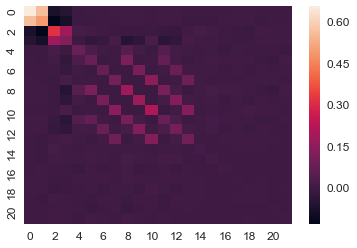

In [30]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

i = 199

sns.heatmap(reconstruct_from_triu(model.predict(dataset.testing[0][i].reshape(1, -1)), 22))

In [31]:
np.mean(
    model.predict(dataset.testing[0][0].reshape(1, -1)) - \
    model.predict(dataset.testing[0][-1].reshape(1, -1))
)

-0.0020011393